In [26]:
# !pip install torch torchvision numpy opencv-python
# !pip install timm
# !pip install matplotlib

In [ ]:
import cv2
import torch
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [14]:
# Load MiDaS model from PyTorch Hub
def load_midas_model():
    model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
    model.eval()
    return model

In [15]:
# Depth map generation with color map
def generate_depth_map_with_color(model, image):
    # Convert the image to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Prepare the input image for the MiDaS model
    transform = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform
    input_tensor = transform(rgb_image)

    # Ensure the tensor has the correct shape [1, 3, height, width]
    if input_tensor.dim() == 3:
        input_tensor = input_tensor.unsqueeze(0)
    elif input_tensor.size(1) == 1:
        input_tensor = input_tensor.squeeze(1)

    # Generate depth map
    with torch.no_grad():
        depth_map = model(input_tensor).squeeze().cpu().numpy()

    # Resize depth map back to original size
    depth_map_resized = cv2.resize(depth_map, (image.shape[1], image.shape[0]))

    # Normalize the depth map to range [0, 255] for color mapping
    depth_map_normalized = cv2.normalize(depth_map_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply a color map (e.g., COLORMAP_JET) to the normalized depth map
    depth_map_colored = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_JET)
    return depth_map_colored


In [16]:

# Depth map generation
def generate_depth_map(model, image):
    # Convert the image to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Prepare the input image for the MiDaS model
    transform = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform
    input_tensor = transform(rgb_image)

    # Ensure the tensor has the correct shape [1, 3, height, width]
    if input_tensor.dim() == 3:
        input_tensor = input_tensor.unsqueeze(0)
    elif input_tensor.size(1) == 1:
        input_tensor = input_tensor.squeeze(1)

    # Generate depth map
    with torch.no_grad():
        depth_map = model(input_tensor).squeeze().cpu().numpy()

    # Resize depth map back to original size
    depth_map_resized = cv2.resize(depth_map, (image.shape[1], image.shape[0]))
    return depth_map_resized

In [17]:

# Find multiple bounding boxes based on similar depth regions
def find_multiple_nearby_objects(image, depth_map, depth_threshold=120, min_contour_area=200):
    # Normalize depth map for easier processing
    normalized_depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Calculate minimum depth and apply a band threshold to get close objects
    min_depth = depth_map.min()
    max_depth = depth_map.max()
    
    # Create a mask for regions within a small range of the minimum depth
    close_depth_mask = np.where((depth_map >= min_depth) & (depth_map <= min_depth + depth_threshold), 255, 0).astype(np.uint8)

    # Find contours in the masked depth map
    contours, _ = cv2.findContours(close_depth_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_with_contours = image.copy()
    
    # Analyze each contour and draw individual bounding boxes
    for contour in contours:
        # Ignore contours that are too small
        if cv2.contourArea(contour) < min_contour_area:
            continue

        # Draw bounding box around the contour
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_with_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.drawContours(image_with_contours, [contour], -1, (255, 0, 0), 2)  # Blue contour for each region

    return image_with_contours


In [18]:

# Find the closest object based on depth contours without inversion
def find_closest_object(image, depth_map, threshold_ratio=0.5, min_contour_area=400):
    # Normalize depth map for easier processing
    normalized_depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Calculate the minimum depth and threshold value to find close objects
    min_depth = depth_map.min()
    max_depth = depth_map.max()
    threshold_value = min_depth + (max_depth - min_depth) * threshold_ratio

    # Apply a binary threshold to select only the nearest regions
    _, binary_map = cv2.threshold(depth_map, threshold_value, 255, cv2.THRESH_BINARY)
    binary_map = binary_map.astype(np.uint8)

    # Find contours in the thresholded depth map
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    nearest_contour = None
    nearest_depth_avg = float('inf')
    
    # Analyze each contour
    for contour in contours:
        # Ignore contours that are too small
        if cv2.contourArea(contour) < min_contour_area:
            continue

        # Create a mask for the contour
        mask = np.zeros(depth_map.shape, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        # Calculate the average depth within the contour
        contour_depth_values = depth_map[mask == 255]
        if contour_depth_values.size == 0:
            continue

        avg_depth = contour_depth_values.mean()

        # Find the contour with the smallest average depth
        if avg_depth < nearest_depth_avg:
            nearest_depth_avg = avg_depth
            nearest_contour = contour

    # Draw bounding box around the nearest contour on the image
    image_with_contour = image.copy()
    if nearest_contour is not None:
        x, y, w, h = cv2.boundingRect(nearest_contour)
        cv2.rectangle(image_with_contour, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.drawContours(image_with_contour, [nearest_contour], -1, (255, 0, 0), 2)  # Blue contour

    return image_with_contour


In [ ]:
image_path = "test2.png"
image = cv2.imread(image_path)

# Load MiDaS model and generate depth map
midas_model = load_midas_model()
depth_map = generate_depth_map_with_color(midas_model, image)
depth_map_gray = generate_depth_map(midas_model, image)

Using cache found in /Users/bereket/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/bereket/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /Users/bereket/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/bereket/.cache/torch/hub/intel-isl_MiDaS_master


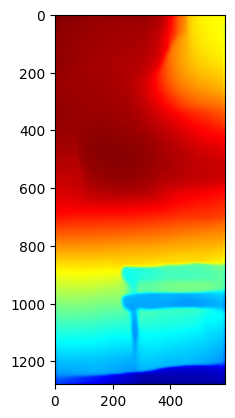

In [28]:
depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
plt.imshow(depth_map_normalized)

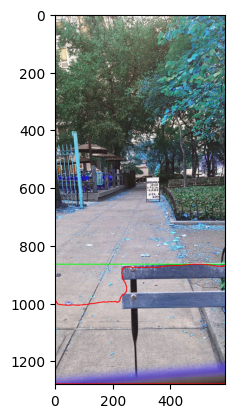

In [ ]:
image_with_box = find_closest_object(image, depth_map_gray)
plt.imshow(image_with_box)